## Cross-Validation

In this notebook, we will optimize hyperparameters with various Cross-Validation Schemes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    train_test_split,
)

In [2]:
# if you want more information about the dataset for this demo:

# scikit-learn dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

# dataset information: UCI Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# percentage of benign (0) and malign tumors (1)

y.value_counts(normalize=True)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## K-Fold Cross-Validation

In [6]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# search
clf =  GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=kf, # k-fold
    refit=True, # refits best model to entire dataset
    n_jobs=-1
)

search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l2'}

In [7]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)
results

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.919620,0.012606
1,"{'C': 0.1, 'penalty': 'l2'}",0.934747,0.019812
2,"{'C': 1, 'penalty': 'l1'}",0.944810,0.024360
3,"{'C': 1, 'penalty': 'l2'}",0.944778,0.025651
4,"{'C': 10, 'penalty': 'l1'}",0.947247,0.014592
5,"{'C': 10, 'penalty': 'l2'}",0.949778,0.013609


Text(0.5, 0, 'Hyperparameter space')

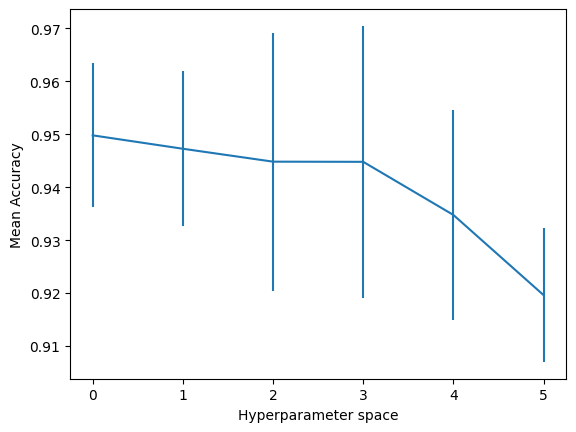

In [10]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [11]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9623115577889447
Test Accuracy:  0.9532163742690059


## Repeated K-Fold

In [12]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# Repeated K-Fold Cross-Validation
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=4,
)

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=rkf, # repeated k-fold
    refit=True, # refits best model to entire dataset
    n_jobs=-1
)

search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l1'}

In [13]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)

results

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.922820,0.022496
1,"{'C': 0.1, 'penalty': 'l2'}",0.932896,0.021612
2,"{'C': 1, 'penalty': 'l1'}",0.948497,0.021488
3,"{'C': 1, 'penalty': 'l2'}",0.945715,0.023271
4,"{'C': 10, 'penalty': 'l1'}",0.955025,0.023470
5,"{'C': 10, 'penalty': 'l2'}",0.952509,0.022965


Text(0.5, 0, 'Hyperparameter space')

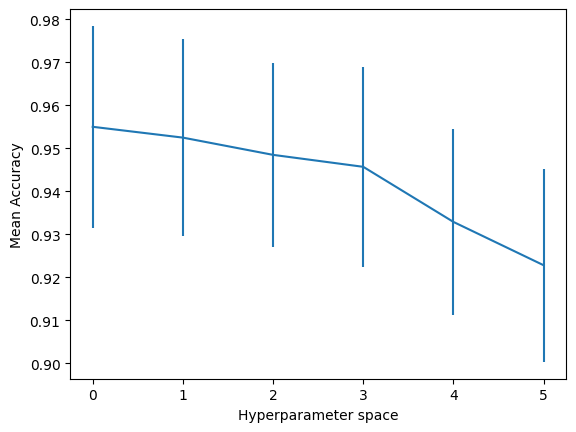

In [14]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [15]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9748743718592965
Test Accuracy:  0.9707602339181286


## Leave One Out

In [17]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# Leave One Out Cross-Validation
loo = LeaveOneOut()

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=loo, # LOOCV
    refit=True, # refits best model to entire dataset
    n_jobs=-1
)

search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l1'}

In [18]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)

results.head()

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.927136,0.259914
1,"{'C': 0.1, 'penalty': 'l2'}",0.934673,0.247101
2,"{'C': 1, 'penalty': 'l1'}",0.949749,0.218463
3,"{'C': 1, 'penalty': 'l2'}",0.944724,0.228519
4,"{'C': 10, 'penalty': 'l1'}",0.959799,0.196430


Text(0.5, 0, 'Hyperparameter space')

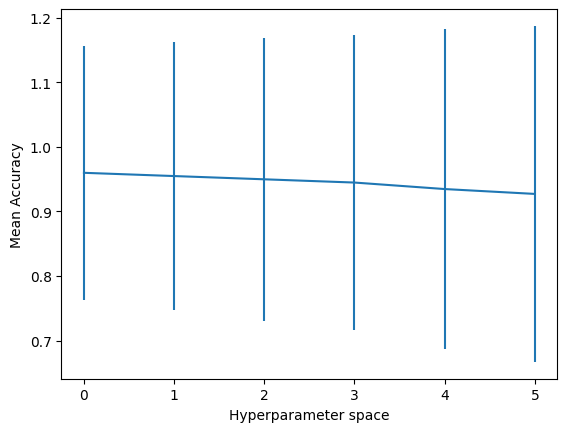

In [19]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [20]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9748743718592965
Test Accuracy:  0.9707602339181286


## Leave P Out

In [21]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# Leave P Out Cross-Validation
lpo = LeavePOut(p=2)

# I take a smaller sample of the data, otherwise
# my computer runs out of memory
X_train_small = X_train.head(30)
y_train_small = y_train.head(30)

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=lpo, # LPOCV
    refit=True, # refits best model to entire dataset
    n_jobs=-1
)

search = clf.fit(X_train_small, y_train_small)

# best hyperparameters
search.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [22]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)

results.head()

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.900000,0.208443
1,"{'C': 0.1, 'penalty': 'l2'}",0.898851,0.209265
2,"{'C': 1, 'penalty': 'l1'}",0.870115,0.226982
3,"{'C': 1, 'penalty': 'l2'}",0.872414,0.225750
4,"{'C': 10, 'penalty': 'l1'}",0.870115,0.226982


Text(0.5, 0, 'Hyperparameter space')

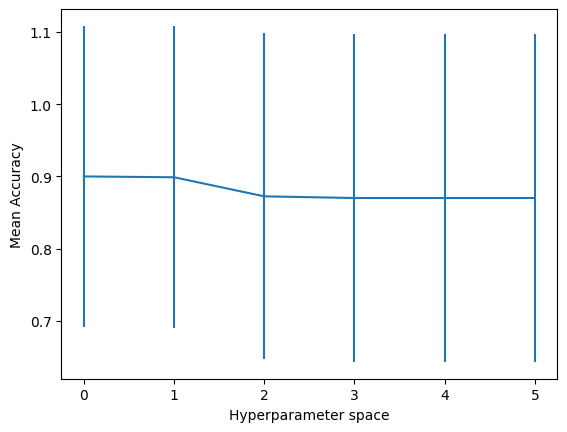

In [23]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [24]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9120603015075377
Test Accuracy:  0.9239766081871345


## Stratified K-Fold Cross-Validation

In [25]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# Leave P Out Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=skf, # LPOCV
    refit=True, # refits best model to entire dataset
    n_jobs=-1
)

search = clf.fit(X_train, y_train)

# best hyperparameters
search.best_params_

{'C': 1, 'penalty': 'l1'}

In [26]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(results.shape)

results.head()

(6, 3)


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.927025,0.020516
1,"{'C': 0.1, 'penalty': 'l2'}",0.926994,0.027246
2,"{'C': 1, 'penalty': 'l1'}",0.949652,0.026659
3,"{'C': 1, 'penalty': 'l2'}",0.944620,0.023649
4,"{'C': 10, 'penalty': 'l1'}",0.947184,0.021802


Text(0.5, 0, 'Hyperparameter space')

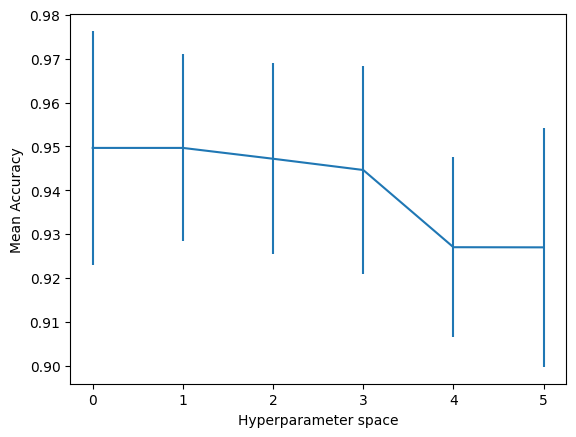

In [27]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [28]:
# let's get the predictions
train_preds = search.predict(X_train)
test_preds = search.predict(X_test)

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9597989949748744
Test Accuracy:  0.9649122807017544
